# 02_check_agumentations.ipynb
purpose: check out augmentations, set up pipeline to allow for augmentation of training and resizing/rescaling of all datasets

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
import numpy as np
import os
import json
import socket
import random
from time import time
from datetime import datetime
from glob import glob
import matplotlib.pyplot as plt
import pathlib
from functools import partial

tf.random.set_seed(1234)
np.random.seed(1234)
K.clear_session()

In [2]:
train_data_dir = '/project/lemay_diet_guthealth/echin/foodphoto/for_github_repro/data/food-101/data_3class/train/'
validation_data_dir = '/project/lemay_diet_guthealth/echin/foodphoto/for_github_repro/data/food-101/data_3class/val/'

In [3]:
n_classes = 3
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
img_size = 299
SEED=1234

In [4]:
#import data 
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_data_dir, labels = "inferred", color_mode = "rgb", image_size = (299,299), 
                                                                 label_mode = "categorical") 
val_data = tf.keras.preprocessing.image_dataset_from_directory(validation_data_dir, labels = "inferred", 
                                                               color_mode = "rgb", image_size = (299,299), label_mode = "categorical")

Found 2400 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [5]:
class_names = train_data.class_names
print(class_names)

['omelette', 'pizza', 'samosa']


In [6]:
train_data

<BatchDataset shapes: ((None, 299, 299, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [7]:
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 299, 299, 3)
(32, 3)


# visualize the data before any processing

In [8]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i].astype('uint8'))
        ax.set_title(f"Label: {label[i]}")

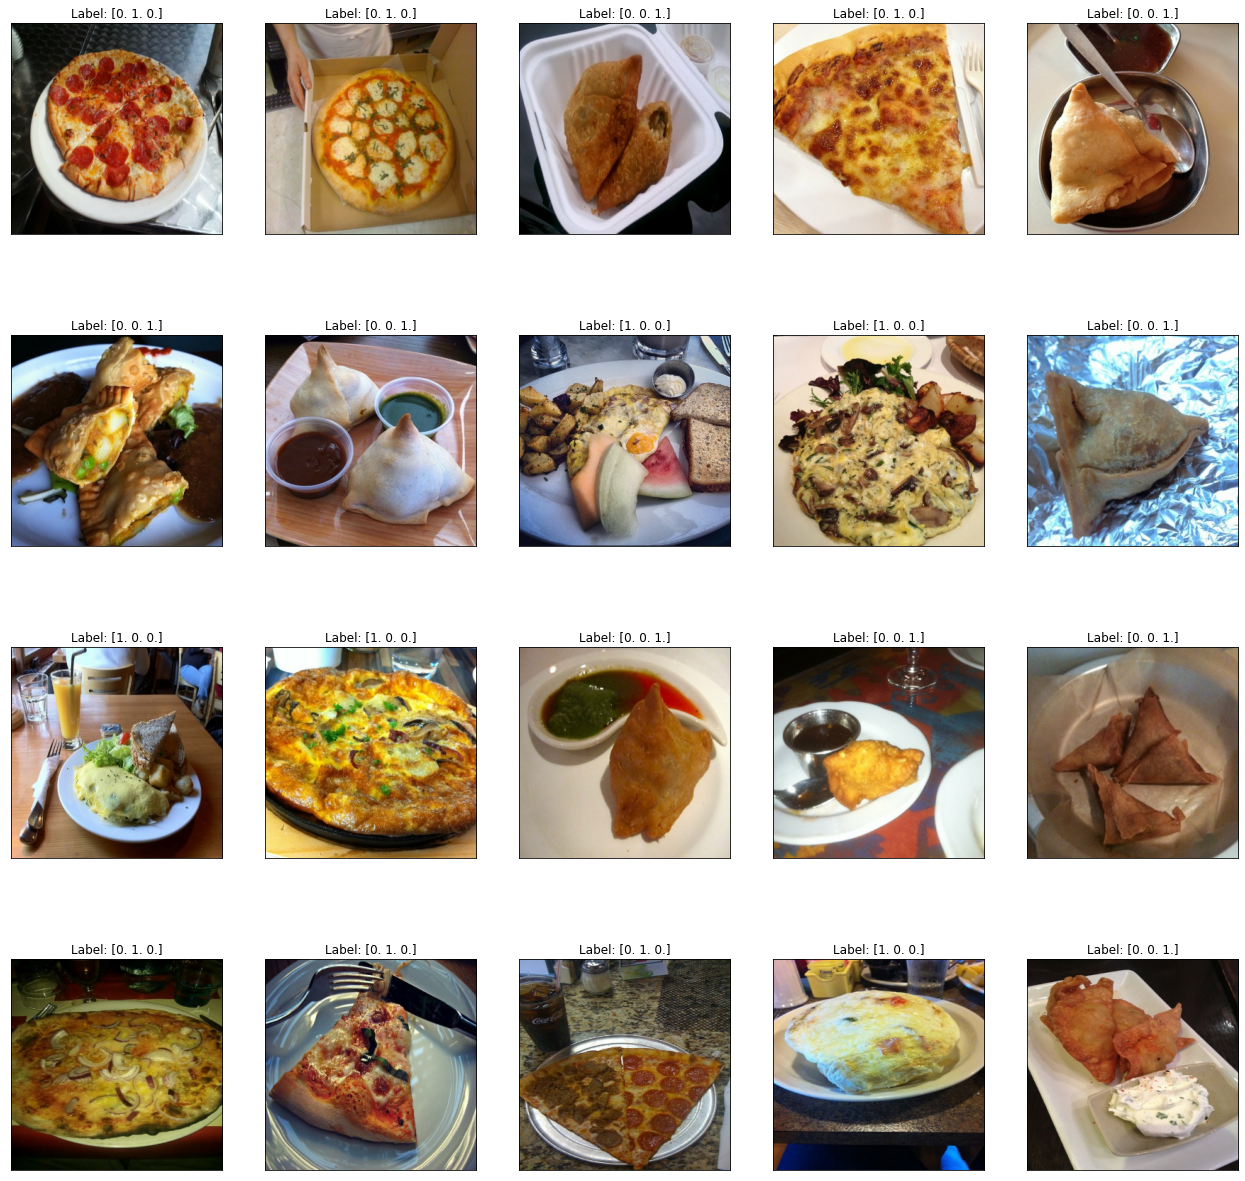

In [9]:
view_image(train_data)

# augment

the values are exaggerated in this example to make sure that the augmentation is doing what we want; change the values to something more realistic for the real thing!

In [10]:
def process_image(image, label, img_size):
    # cast and normalize image
    image = tf.image.convert_image_dtype(image, tf.float32)
    # apply simple augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta = 0.95, seed = SEED) #exaggerate the brightness so we can make sure it works
    image = tf.image.random_contrast(image, lower = 0, upper = 0.2, seed = SEED) #exaggerate the contrast so we can make sure it works
    image = tf.image.resize(image,[img_size, img_size])
    return image, label

In [11]:
ds_tf = train_data.map(partial(process_image, img_size=299),num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_tf

<PrefetchDataset shapes: ((None, 299, 299, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [12]:
image_batch, label_batch = next(iter(ds_tf))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 

65.41608 152.4889


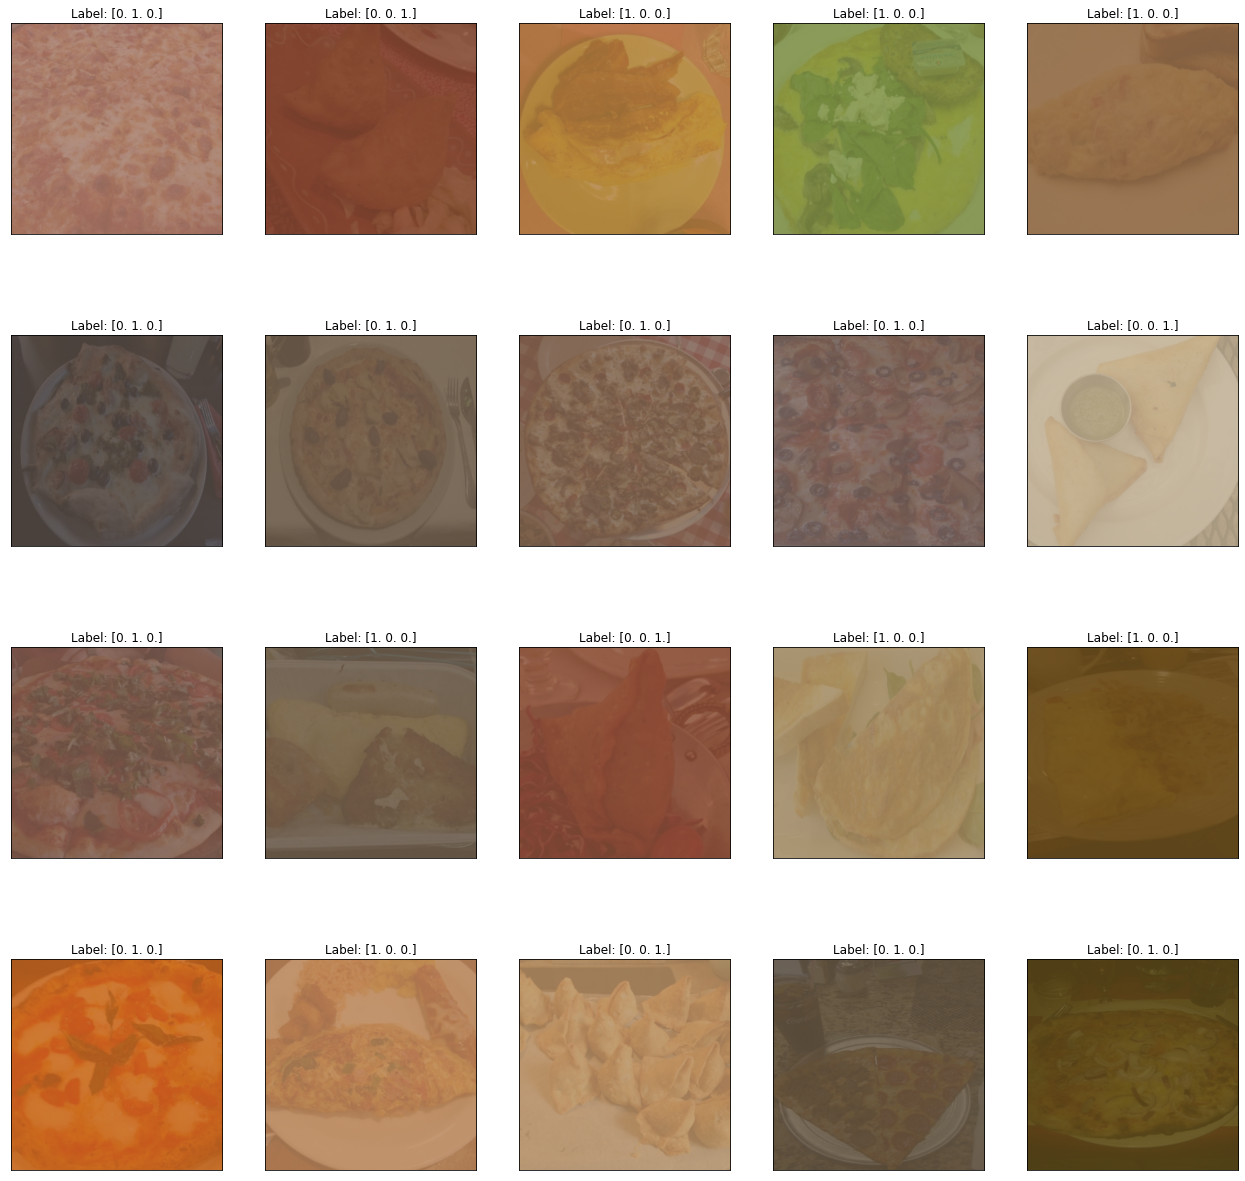

In [13]:
view_image(ds_tf)

# Normalize/scale

In [14]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
#apply to dataset with map
train_norm = ds_tf.map(lambda x, y: (normalization_layer(x), y),num_parallel_calls = AUTOTUNE).prefetch(AUTOTUNE)
image_batch, labels_batch = next(iter(train_norm))
first_image = image_batch[0]
#notice the pixel values are now in [0,1]
print(np.min(first_image), np.max(first_image))


val_norm = val_data.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls = AUTOTUNE).prefetch(AUTOTUNE)

0.33652574 0.7402742


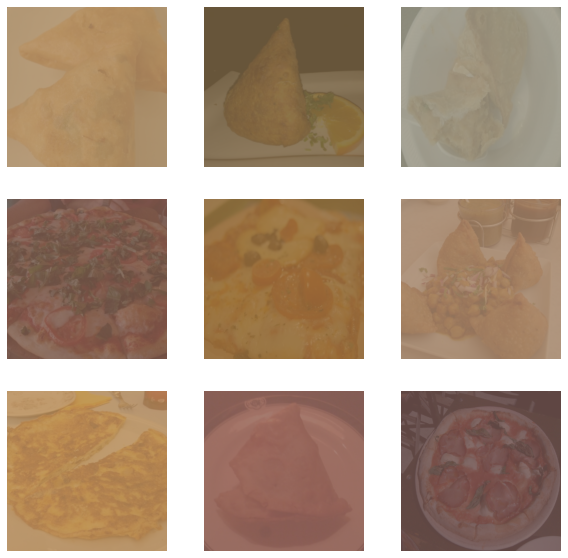

In [16]:
image_batch, label_batch = next(iter(train_norm))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  label = label_batch[i]
  #plt.title(class_names[label])
  plt.axis("off")

put it all together: 

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_size, img_size),
  layers.experimental.preprocessing.Rescaling(1./255)
])

def process_image(image, label, img_size, augment = False):
    if augment:
        # apply augmentations
        image = tf.image.random_flip_left_right(image, seed = SEED)
        image = tf.image.random_brightness(image, max_delta = 0.6, seed = SEED)
        image = tf.image.random_contrast(image, lower = 0, upper = 0.9, seed = SEED)
        
    image= resize_and_rescale(image)

    return image, label

In [18]:
train_tf = train_data.map(partial(process_image, img_size=299, augment = True),num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
val_tf = val_data.map(partial(process_image, img_size=299, augment = False),num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE) #validation and test data don't get augmented 

visualize the training data: 

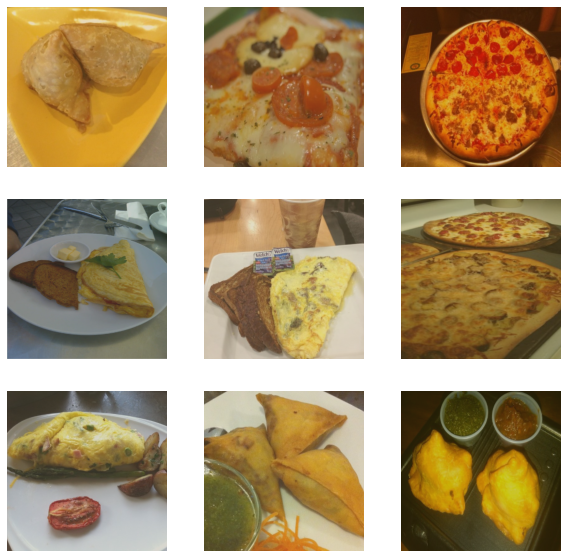

In [19]:
image_batch, label_batch = next(iter(train_tf))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  label = label_batch[i]
  #plt.title(class_names[label])
  plt.axis("off")

visualize the validation data: 

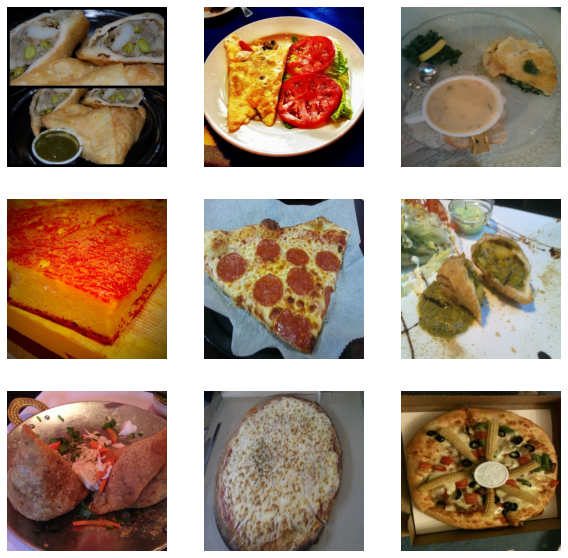

In [20]:
image_batch, label_batch = next(iter(val_tf))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  label = label_batch[i]
  #plt.title(class_names[label])
  plt.axis("off")